# Course Completion Prediction

Задача: создать и обучить классификатор предсказывать, закончит ли студент курс (по его активности за первые несколько дней).

**events_train.csv** - данные о действиях, которые совершают студенты со стэпами

1. step_id - id стэпа
2. user_id - анонимизированный id юзера
3. timestamp - время наступления события в формате unix date
4. action - событие, возможные значения: 
* discovered - пользователь перешел на стэп
* viewed - просмотр шага
* started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
* passed - удачное решение практического шага

In [24]:
import pandas as pd
import numpy as np

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize': (9,6)})

## Первичный анализ данных

In [25]:
events = pd.read_csv('/Users/kamila/Downloads/event_data_train.csv')

In [26]:
events.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [27]:
events.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [28]:
events['date'] = pd.to_datetime(events.timestamp, unit='s')

In [29]:
events.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [30]:
events.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [31]:
events.date.min()

Timestamp('2015-06-15 04:00:48')

In [32]:
events.date.max()

Timestamp('2018-05-19 23:33:31')

In [33]:
events['day'] = events.date.dt.date

In [34]:
events.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [35]:
events.groupby('day').user_id.nunique().head() # считаем сколько уникальных пользователей в каждом дне

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
Name: user_id, dtype: int64

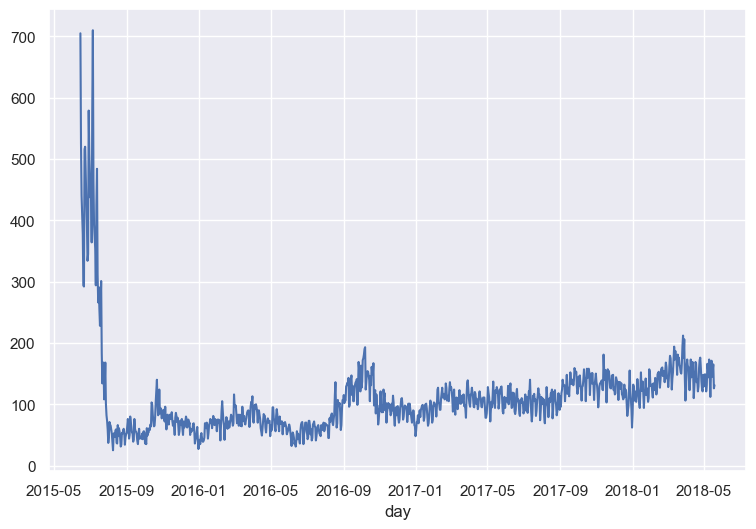

In [43]:
events.groupby('day').user_id.nunique().plot() #визуализируем
plt.show()

In [62]:
#количество степов каждого вида для каждого юзера
users_actions = events.pivot_table(index = 'user_id', columns = 'action', values = 'step_id', aggfunc = 'count', fill_value = 0) \
.rename_axis(None, axis=1) 

In [63]:
users_actions

,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1
...,...,...,...,...
26790,8,8,1,9
26793,1,0,1,1
26794,69,69,34,180


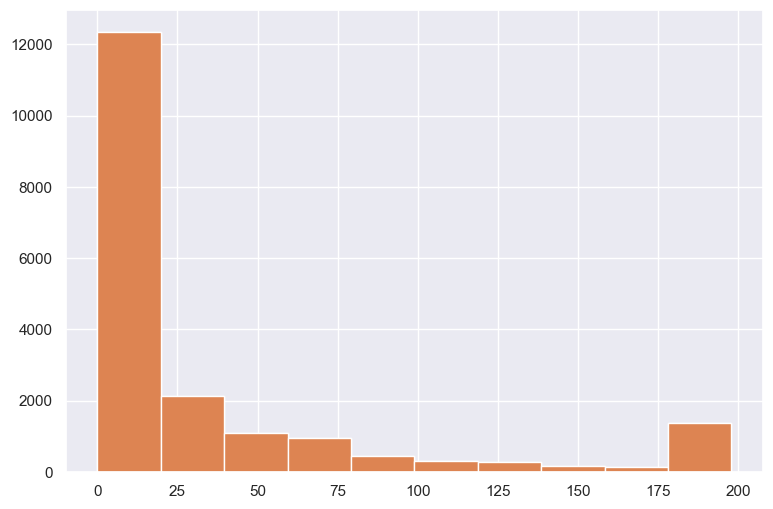

In [65]:
#визуализируем
events.pivot_table(index = 'user_id', columns = 'action', values = 'step_id', aggfunc = 'count', fill_value = 0).passed.hist()
plt.show()

**submissions_train.csv** - данные о времени и статусах сабмитов к практическим заданиям

1. step_id - id стэпа
2. timestamp - время отправки решения в формате unix date
3. submission_status - статус решения
4. user_id - анонимизированный id юзера

In [66]:
submissions = pd.read_csv('/Users/kamila/Downloads/submissions_data_train.csv')

In [67]:
submissions.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [68]:
submissions['date'] = pd.to_datetime(submissions.timestamp, unit='s') 

In [69]:
submissions.head()

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03


In [70]:
submissions['day'] = submissions.date.dt.date
submissions.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [71]:
scores = submissions.pivot_table(index = 'user_id', columns = 'submission_status', values = 'step_id', aggfunc = 'count', fill_value = 0) \
.rename_axis(None, axis=1)

In [72]:
scores

,correct,wrong
user_id,,
2,2,0
3,29,23
5,2,2
8,9,21
14,0,1
...,...,...
26787,3,0
26790,1,0
26794,33,9


Многие студенты из табличных данных еще не закончили курс, но и не ушли с него, а находятся в процессе обучения. Чтобы понять, какие студенты относятся к навсегда ушедшим с курса, а какие к тем, кто в процессе его прохождения, я хочу найти такую длительность перерыва в прохождении курса, после которого обычно студенты с него уходят.  
Считаем перерывы в обучении студентов, чтоб понять после какой длительности перерыва они обычно уходят с курса навсегда => то есть ищем пороговое значение для отсеивания дропнувшихся с курса студентов:

In [74]:
events.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [75]:
events[['user_id', 'day', 'timestamp']].head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
1,17632,2015-06-15,1434340848
2,17632,2015-06-15,1434340848
3,17632,2015-06-15,1434340895
4,17632,2015-06-15,1434340895


In [77]:
#у каждого юзера все уникальные степы за день:
events[['user_id', 'day', 'timestamp']].drop_duplicates().head() 

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
3,17632,2015-06-15,1434340895
6,17632,2015-06-15,1434340921
8,17632,2015-06-15,1434340939
9,17632,2015-06-15,1434340944


In [78]:
#у каждого юзера по одному из уникальных степов в день -> уникальные дни захода:
events[['user_id', 'day', 'timestamp']].drop_duplicates(subset = ['user_id', 'day']).head() 

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


In [79]:
#для каждого юзера сохраняем список таймстемпов уникальных дней захода
events[['user_id', 'day', 'timestamp']].drop_duplicates(subset = ['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list)

user_id
1                                             [1472827464]
2                                 [1514383364, 1519226966]
3        [1434358476, 1441257725, 1441440209, 144153391...
5                                 [1466156809, 1499859621]
7                                             [1521634660]
                               ...                        
26790     [1451484016, 1451722241, 1452616205, 1517495853]
26793                                         [1510225031]
26794    [1495287049, 1495373177, 1495509936, 149560483...
26797                             [1508425316, 1509993306]
26798                                         [1520975763]
Name: timestamp, Length: 19234, dtype: object

In [87]:
#считаем разности между этими таймстемпами, то есть перерывы между степами
gaps = events[['user_id', 'day', 'timestamp']].drop_duplicates(subset = ['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values
gaps

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

In [88]:
np.concatenate(gaps, axis = 0) #переводим массив массивов в один массив

array([4843602, 6899249,  182484, ...,   98252,   57019, 1567990])

In [89]:
gaps = pd.Series(np.concatenate(gaps, axis = 0)) #переводим массив в пандовскую серию
gaps

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int64

In [90]:
gaps = gaps / (60 * 60 * 24) #разница в днях
gaps

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

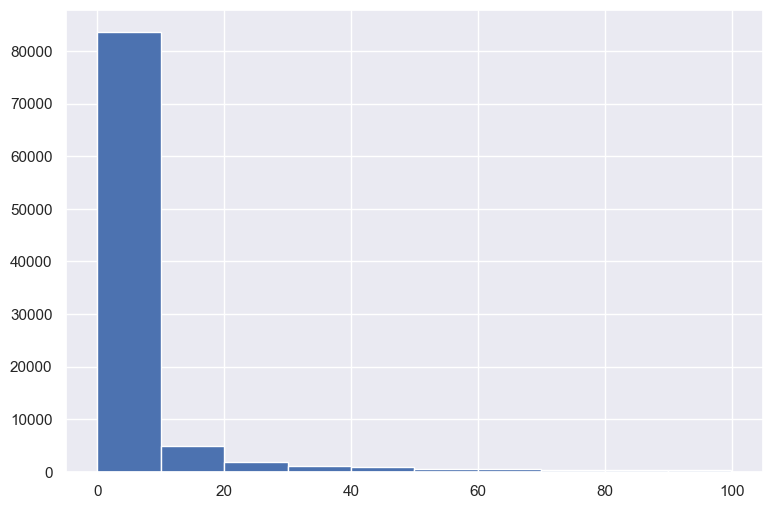

In [96]:
gaps[gaps < 100].hist() #отобрала наблюдения меньше 100, чтобы было видно что происходит дальше по оси х 
plt.show()

In [97]:
gaps.quantile(0.925) #большая часть гэпов (перерывов между степами) укладывается в диапазон из стольких дней:

np.float64(30.629370081018546)

То есть только 7,5% студентов возвращается на курс спустя 30 дней.

### Считаем ушедших с курса

In [98]:
now = events.timestamp.max()
now

1526772811

In [99]:
threshold = 30 * 24 * 60 * 60  #30 - пороговое значение, которое мы определили ранее, и тут перевели в сек (timestamp)
threshold

2592000

In [103]:
#считаем последний таймстемп каждого юзера:
users_data = events.groupby('user_id').agg({'timestamp': 'max'}).rename(columns = {'timestamp': 'last_timestamp'})

In [106]:
#если время между последним таймстемпом юзера и нынешним тайстемпом больше нашего порога, то юзер отвалился с курса
#(пока не учитываем тех, кто закончил курс, это сделаю позже):
users_data['gone'] = (now - users_data.last_timestamp) > threshold
users_data

,last_timestamp,gone
user_id,,
1,1472827464,True
2,1519226966,True
3,1444581588,True
5,1499859939,True
7,1521634660,True
...,...,...
26790,1517495987,True
26793,1510225034,True
26794,1512035039,True


In [107]:
users_data[users_data.gone == False] #просто чекнула существуют ли фолзы

,last_timestamp,gone
user_id,,
11,1526140625,False
24,1524764853,False
25,1524816605,False
32,1524752239,False
34,1525626844,False
...,...,...
26619,1524331016,False
26659,1526770439,False
26661,1524570207,False


### Смерджим данные таблиц users_data и scores:

In [109]:
scores

,correct,wrong
user_id,,
2,2,0
3,29,23
5,2,2
8,9,21
14,0,1
...,...,...
26787,3,0
26790,1,0
26794,33,9


In [110]:
users_data

,last_timestamp,gone
user_id,,
1,1472827464,True
2,1519226966,True
3,1444581588,True
5,1499859939,True
7,1521634660,True
...,...,...
26790,1517495987,True
26793,1510225034,True
26794,1512035039,True


In [111]:
users_data = users_data.merge(scores, on = 'user_id', how = 'outer')
users_data

,last_timestamp,gone,correct,wrong
user_id,,,,
1,1472827464,True,NaN,NaN
2,1519226966,True,2.0,0.0
3,1444581588,True,29.0,23.0
5,1499859939,True,2.0,2.0
7,1521634660,True,NaN,NaN
...,...,...,...,...
26790,1517495987,True,1.0,0.0
26793,1510225034,True,NaN,NaN
26794,1512035039,True,33.0,9.0


In [112]:
users_data = users_data.fillna(0) #заполняем наны нулями
users_data

,last_timestamp,gone,correct,wrong
user_id,,,,
1,1472827464,True,0.0,0.0
2,1519226966,True,2.0,0.0
3,1444581588,True,29.0,23.0
5,1499859939,True,2.0,2.0
7,1521634660,True,0.0,0.0
...,...,...,...,...
26790,1517495987,True,1.0,0.0
26793,1510225034,True,0.0,0.0
26794,1512035039,True,33.0,9.0


In [43]:
users_actions

,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1
...,...,...,...,...
26790,8,8,1,9
26793,1,0,1,1
26794,69,69,34,180


In [113]:
users_data = users_data.merge(users_actions, on = 'user_id', how = 'outer')
users_data

,last_timestamp,gone,correct,wrong,discovered,passed,started_attempt,viewed
user_id,,,,,,,,
1,1472827464,True,0.0,0.0,1,0,0,1
2,1519226966,True,2.0,0.0,9,9,2,10
3,1444581588,True,29.0,23.0,91,87,30,192
5,1499859939,True,2.0,2.0,11,11,4,12
7,1521634660,True,0.0,0.0,1,1,0,1
...,...,...,...,...,...,...,...,...
26790,1517495987,True,1.0,0.0,8,8,1,9
26793,1510225034,True,0.0,0.0,1,0,1,1
26794,1512035039,True,33.0,9.0,69,69,34,180


In [114]:
events

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


In [119]:
users_days = events.groupby('user_id').day.nunique() #создали серию с количеством уникальных дней для каждого пользователя
users_days

user_id
1        1
2        2
3        7
5        2
7        1
        ..
26790    4
26793    1
26794    9
26797    2
26798    1
Name: day, Length: 19234, dtype: int64

In [120]:
users_days = users_days.to_frame()
users_days

,day
user_id,
1,1
2,2
3,7
5,2
7,1
...,...
26790,4
26793,1
26794,9


In [121]:
users_data = users_data.merge(users_days, on = 'user_id', how = 'outer')
users_data

,last_timestamp,gone,correct,wrong,discovered,passed,started_attempt,viewed,day
user_id,,,,,,,,,
1,1472827464,True,0.0,0.0,1,0,0,1,1
2,1519226966,True,2.0,0.0,9,9,2,10,2
3,1444581588,True,29.0,23.0,91,87,30,192,7
5,1499859939,True,2.0,2.0,11,11,4,12,2
7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...
26790,1517495987,True,1.0,0.0,8,8,1,9,4
26793,1510225034,True,0.0,0.0,1,0,1,1,1
26794,1512035039,True,33.0,9.0,69,69,34,180,9


In [122]:
len(users_data)

19234

In [124]:
events.user_id.nunique() #проверили, что никого не потеряли

19234

In [125]:
users_data['passed_course'] = users_data.passed > 170 #прошел ли юзер курс/получил сертификат
users_data

,last_timestamp,gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
user_id,,,,,,,,,,
1,1472827464,True,0.0,0.0,1,0,0,1,1,False
2,1519226966,True,2.0,0.0,9,9,2,10,2,False
3,1444581588,True,29.0,23.0,91,87,30,192,7,False
5,1499859939,True,2.0,2.0,11,11,4,12,2,False
7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...
26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
26794,1512035039,True,33.0,9.0,69,69,34,180,9,False


In [126]:
users_data = users_data.reset_index()

In [128]:
users_data[users_data.passed_course == True] #проверка что они существуют

,user_id,last_timestamp,gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
9,16,1513162585,True,77.0,106.0,196,196,108,651,21,True
13,22,1507142631,True,76.0,47.0,198,198,89,492,32,True
18,30,1510574287,True,119.0,79.0,198,198,150,512,42,True
22,34,1525626844,False,77.0,85.0,198,195,92,1013,60,True
26,39,1502712399,True,77.0,29.0,198,198,88,1160,170,True
...,...,...,...,...,...,...,...,...,...,...,...
19190,26740,1463224362,True,71.0,45.0,193,188,96,670,18,True
19207,26763,1436216740,True,75.0,156.0,193,193,93,391,12,True
19218,26777,1436605200,True,73.0,104.0,193,191,120,422,15,True
19220,26779,1520157100,True,76.0,41.0,196,196,111,379,38,True


In [129]:
users_data.groupby('passed_course')['user_id'].count() #количество закончивших и незакончивших курс

passed_course
False    17809
True      1425
Name: user_id, dtype: int64

In [131]:
(1425 / (1425 + 17809)) * 100 #процент закончивших курс из всех студентов

7.408755329104711

## Готовим датасет к предсказанию по первым 3 дням

In [141]:
users_data[users_data['passed_course'] == True]['day'].median() #сколько в среднем дней понадобилось студентам, чтобы пройти курс

20.0

In [147]:
#ищем минимальный таймстемп - время самого первого действия с курсом каждого юзера
#берем не из юзерсов а из ивентсов потому что в юзерсах только по одному последнему таймстемпу каждого юзера
min_time = events.groupby('user_id').agg({'timestamp': 'min'}).reset_index().rename({'timestamp': 'min_timestamp'}, axis = 1)
min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [150]:
#добавляем к основной таблице юзерс
users_data = users_data.merge(min_time, how = 'outer')
users_data

,user_id,last_timestamp,gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


Нам нужно отобрать все действия юзеров только в период трех дней:

In [166]:
events1 = events.merge(min_time, how = 'outer')
events1

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1472827464
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1472827464
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,1514383364
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,1514383364
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,1514383364
...,...,...,...,...,...,...,...
3480698,31956,1520978499,passed,26798,2018-03-13 22:01:39,2018-03-13,1520975763
3480699,31956,1520978499,viewed,26798,2018-03-13 22:01:39,2018-03-13,1520975763
3480700,31955,1520978742,passed,26798,2018-03-13 22:05:42,2018-03-13,1520975763
3480701,31955,1520978742,discovered,26798,2018-03-13 22:05:42,2018-03-13,1520975763


In [183]:
events_train = events1[events1.timestamp <= (events1.min_timestamp + 3*24*60*60)]
events_train

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1472827464
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1472827464
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,1514383364
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,1514383364
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,1514383364
...,...,...,...,...,...,...,...
3480698,31956,1520978499,passed,26798,2018-03-13 22:01:39,2018-03-13,1520975763
3480699,31956,1520978499,viewed,26798,2018-03-13 22:01:39,2018-03-13,1520975763
3480700,31955,1520978742,passed,26798,2018-03-13 22:05:42,2018-03-13,1520975763
3480701,31955,1520978742,discovered,26798,2018-03-13 22:05:42,2018-03-13,1520975763


То же самое для сабмишнс:

In [210]:
submissions1 = submissions.merge(min_time, how = 'outer')
submissions1

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp
0,NaN,NaN,NaN,1,NaT,NaN,1472827464
1,32812.0,1.514383e+09,correct,2,2017-12-27 14:04:45,2017-12-27,1514383364
2,32929.0,1.514383e+09,correct,2,2017-12-27 14:03:40,2017-12-27,1514383364
3,31971.0,1.441259e+09,correct,3,2015-09-03 05:47:46,2015-09-03,1434358476
4,31972.0,1.441259e+09,correct,3,2015-09-03 05:39:03,2015-09-03,1434358476
...,...,...,...,...,...,...,...
518393,32812.0,1.508426e+09,correct,26797,2017-10-19 15:10:28,2017-10-19,1508425316
518394,32929.0,1.508425e+09,correct,26797,2017-10-19 15:02:47,2017-10-19,1508425316
518395,32812.0,1.520978e+09,wrong,26798,2018-03-13 21:54:23,2018-03-13,1520975763
518396,32812.0,1.520978e+09,correct,26798,2018-03-13 21:54:30,2018-03-13,1520975763


In [211]:
submissions_train = submissions1[submissions1.timestamp <= (submissions1.min_timestamp + 3*24*60*60)]
submissions_train

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp
1,32812.0,1.514383e+09,correct,2,2017-12-27 14:04:45,2017-12-27,1514383364
2,32929.0,1.514383e+09,correct,2,2017-12-27 14:03:40,2017-12-27,1514383364
6,31977.0,1.434359e+09,wrong,3,2015-06-15 09:10:32,2015-06-15,1434358476
7,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:00,2015-06-15,1434358476
8,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:21,2015-06-15,1434358476
...,...,...,...,...,...,...,...
518393,32812.0,1.508426e+09,correct,26797,2017-10-19 15:10:28,2017-10-19,1508425316
518394,32929.0,1.508425e+09,correct,26797,2017-10-19 15:02:47,2017-10-19,1508425316
518395,32812.0,1.520978e+09,wrong,26798,2018-03-13 21:54:23,2018-03-13,1520975763
518396,32812.0,1.520978e+09,correct,26798,2018-03-13 21:54:30,2018-03-13,1520975763


In [192]:
#проверяем максимальное количество дней, которое может быть для пользователя 
#(максимум может быть 4, потому что пользователь может начать учиться в середине дня, тогда он захватит четвертый день)
events_train.groupby('user_id').day.nunique().max() 

4

In [212]:
#то же самое для сабмишнс:
submissions_train.groupby('user_id').day.nunique().max() 

4

## Поиск степа, который отпугнул большинство пользователей

In [189]:
last_step = submissions.loc[submissions.groupby('user_id')['timestamp'].idxmax(), ['user_id', 'step_id', 'submission_status']]
last_step

,user_id,step_id,submission_status
506853,2,32812,correct
114961,3,33538,correct
505569,5,32812,correct
500024,8,33332,correct
509054,14,33983,wrong
...,...,...,...
491467,26787,32219,correct
508280,26790,32929,correct
318273,26794,32812,correct
506152,26797,32812,correct


In [190]:
wrong_last_step = last_step[last_step['submission_status'] == 'wrong']
wrong_last_step

,user_id,step_id,submission_status
509054,14,33983,wrong
500434,17,32031,wrong
507983,25,32812,wrong
495732,31,31976,wrong
307375,34,33669,wrong
...,...,...,...
375351,26666,32031,wrong
51385,26676,33536,wrong
264341,26703,33685,wrong
410335,26737,31981,wrong


In [191]:
wrong_last_step['step_id'].mode()

0    31978
Name: step_id, dtype: int64

In [106]:
#еще способ

In [110]:
sub_us = submissions.merge(users_data[['last_timestamp', 'user_id']], on='user_id', how='outer')
sub_us

,step_id,timestamp,submission_status,user_id,date,day,last_timestamp
0,NaN,NaN,NaN,1,NaN,NaN,1472827464
1,32812.0,1.514383e+09,correct,2,2017-12-27 14:04:45,2017-12-27,1519226966
2,32929.0,1.514383e+09,correct,2,2017-12-27 14:03:40,2017-12-27,1519226966
3,31971.0,1.441259e+09,correct,3,2015-09-03 05:47:46,2015-09-03,1444581588
4,31972.0,1.441259e+09,correct,3,2015-09-03 05:39:03,2015-09-03,1444581588
...,...,...,...,...,...,...,...
518393,32812.0,1.508426e+09,correct,26797,2017-10-19 15:10:28,2017-10-19,1509995096
518394,32929.0,1.508425e+09,correct,26797,2017-10-19 15:02:47,2017-10-19,1509995096
518395,32812.0,1.520978e+09,wrong,26798,2018-03-13 21:54:23,2018-03-13,1520978742
518396,32812.0,1.520978e+09,correct,26798,2018-03-13 21:54:30,2018-03-13,1520978742


In [108]:
wrong_sub_us = sub_us[sub_us['submission_status'] == 'wrong']
wrong_sub_us

,step_id,timestamp,submission_status,user_id,date,day,last_timestamp
6,31977.0,1.434359e+09,wrong,3,2015-06-15 09:10:32,2015-06-15,1444581588
7,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:00,2015-06-15,1444581588
8,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:21,2015-06-15,1444581588
13,31983.0,1.441488e+09,wrong,3,2015-09-05 21:21:34,2015-09-05,1444581588
14,31983.0,1.441488e+09,wrong,3,2015-09-05 21:22:00,2015-09-05,1444581588
...,...,...,...,...,...,...,...
518377,32202.0,1.495379e+09,wrong,26794,2017-05-21 15:09:23,2017-05-21,1512035039
518381,32244.0,1.495396e+09,wrong,26794,2017-05-21 19:43:25,2017-05-21,1512035039
518384,32244.0,1.495529e+09,wrong,26794,2017-05-23 08:40:17,2017-05-23,1512035039
518388,32810.0,1.495525e+09,wrong,26794,2017-05-23 07:33:17,2017-05-23,1512035039


In [109]:
wrong_sub_us['step_id'].mode()

0    31978.0
Name: step_id, dtype: float64

## Собираем датасеты для модели (фичи и таргет)

In [213]:
submissions_train

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp
1,32812.0,1.514383e+09,correct,2,2017-12-27 14:04:45,2017-12-27,1514383364
2,32929.0,1.514383e+09,correct,2,2017-12-27 14:03:40,2017-12-27,1514383364
6,31977.0,1.434359e+09,wrong,3,2015-06-15 09:10:32,2015-06-15,1434358476
7,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:00,2015-06-15,1434358476
8,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:21,2015-06-15,1434358476
...,...,...,...,...,...,...,...
518393,32812.0,1.508426e+09,correct,26797,2017-10-19 15:10:28,2017-10-19,1508425316
518394,32929.0,1.508425e+09,correct,26797,2017-10-19 15:02:47,2017-10-19,1508425316
518395,32812.0,1.520978e+09,wrong,26798,2018-03-13 21:54:23,2018-03-13,1520975763
518396,32812.0,1.520978e+09,correct,26798,2018-03-13 21:54:30,2018-03-13,1520975763


In [265]:
#добавим в Х количество уникальных дней каждого пользователя (за 3 дня)
X = submissions_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns = {'day': 'days'})
X

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
...,...,...
8908,26787,1
8909,26790,1
8910,26794,3
8911,26797,1


In [266]:
#добавим инфу о том сколько степов попытался пройти юзер за первые 3 дня
X = X.merge((submissions_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns = {'step_id': 'steps'})), \
           on = 'user_id', how = 'outer')
X

,user_id,days,steps
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23
...,...,...,...
8908,26787,1,3
8909,26790,1,1
8910,26794,3,27
8911,26797,1,2


In [267]:
#добавим количество правильных и количество неправильных степов
X = X.merge(submissions_train.pivot_table(index = 'user_id', 
                             columns = 'submission_status',
                             values = 'step_id', 
                             aggfunc = 'count',
                             fill_value = 0).reset_index(), how = 'outer')
X

,user_id,days,steps,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


In [268]:
#добавим отношение правильных попыток ко всем
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X

,user_id,days,steps,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,3,23,23,27,0.460000
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.000000
8909,26790,1,1,1,0,1.000000
8910,26794,3,27,31,9,0.775000
8911,26797,1,2,2,0,1.000000


In [225]:
events_train

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1472827464
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1472827464
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,1514383364
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,1514383364
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,1514383364
...,...,...,...,...,...,...,...
3480698,31956,1520978499,passed,26798,2018-03-13 22:01:39,2018-03-13,1520975763
3480699,31956,1520978499,viewed,26798,2018-03-13 22:01:39,2018-03-13,1520975763
3480700,31955,1520978742,passed,26798,2018-03-13 22:05:42,2018-03-13,1520975763
3480701,31955,1520978742,discovered,26798,2018-03-13 22:05:42,2018-03-13,1520975763


In [269]:
#добавим количество степов по каждому действию
X = X.merge(events_train.pivot_table(index = 'user_id', 
                                 columns = 'action',
                                 values = 'step_id', 
                                 aggfunc = 'count',
                                 fill_value = 0).reset_index(), how = 'outer')
X

,user_id,days,steps,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed
0,1,NaN,NaN,NaN,NaN,NaN,1,0,0,1
1,2,1.0,2.0,2.0,0.0,1.000000,9,9,2,9
2,3,1.0,4.0,4.0,4.0,0.500000,15,15,4,20
3,5,NaN,NaN,NaN,NaN,NaN,1,1,0,1
4,7,NaN,NaN,NaN,NaN,NaN,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1.0,1.0,1.0,0.0,1.000000,6,6,1,6
19230,26793,NaN,NaN,NaN,NaN,NaN,1,0,1,1
19231,26794,3.0,27.0,31.0,9.0,0.775000,61,61,32,134
19232,26797,1.0,2.0,2.0,0.0,1.000000,10,10,2,10


In [270]:
X = X.fillna(0)
X

,user_id,days,steps,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed
0,1,0.0,0.0,0.0,0.0,0.000000,1,0,0,1
1,2,1.0,2.0,2.0,0.0,1.000000,9,9,2,9
2,3,1.0,4.0,4.0,4.0,0.500000,15,15,4,20
3,5,0.0,0.0,0.0,0.0,0.000000,1,1,0,1
4,7,0.0,0.0,0.0,0.0,0.000000,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1.0,1.0,1.0,0.0,1.000000,6,6,1,6
19230,26793,0.0,0.0,0.0,0.0,0.000000,1,0,1,1
19231,26794,3.0,27.0,31.0,9.0,0.775000,61,61,32,134
19232,26797,1.0,2.0,2.0,0.0,1.000000,10,10,2,10


In [230]:
users_data

,user_id,last_timestamp,gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


In [271]:
X = X.merge(users_data[['user_id', 'passed_course', 'gone']], how = 'outer')
X

,user_id,days,steps,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed,passed_course,gone
0,1,0.0,0.0,0.0,0.0,0.000000,1,0,0,1,False,True
1,2,1.0,2.0,2.0,0.0,1.000000,9,9,2,9,False,True
2,3,1.0,4.0,4.0,4.0,0.500000,15,15,4,20,False,True
3,5,0.0,0.0,0.0,0.0,0.000000,1,1,0,1,False,True
4,7,0.0,0.0,0.0,0.0,0.000000,1,1,0,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1.0,1.0,1.0,0.0,1.000000,6,6,1,6,False,True
19230,26793,0.0,0.0,0.0,0.0,0.000000,1,0,1,1,False,True
19231,26794,3.0,27.0,31.0,9.0,0.775000,61,61,32,134,False,True
19232,26797,1.0,2.0,2.0,0.0,1.000000,10,10,2,10,False,True


In [272]:
#надо выкинуть пользователей, которые еще в процессе прохождения курса, 
#потому что мы не знаем их результат (уйдут или нет с курса), а для обучения нужен результат
X = X[~((X.gone == False) & (X.passed_course == False))]
X

,user_id,days,steps,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed,passed_course,gone
0,1,0.0,0.0,0.0,0.0,0.000000,1,0,0,1,False,True
1,2,1.0,2.0,2.0,0.0,1.000000,9,9,2,9,False,True
2,3,1.0,4.0,4.0,4.0,0.500000,15,15,4,20,False,True
3,5,0.0,0.0,0.0,0.0,0.000000,1,1,0,1,False,True
4,7,0.0,0.0,0.0,0.0,0.000000,1,1,0,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1.0,1.0,1.0,0.0,1.000000,6,6,1,6,False,True
19230,26793,0.0,0.0,0.0,0.0,0.000000,1,0,1,1,False,True
19231,26794,3.0,27.0,31.0,9.0,0.775000,61,61,32,134,False,True
19232,26797,1.0,2.0,2.0,0.0,1.000000,10,10,2,10,False,True


| gone | passed_course | статус юзера |
| :--- | :---: | ---: |
| False | False | в процессе прохождения курса |
| False | True | прошел курс только что |
| True | True | прошел курс давно |
| True | False | дропнулся с курса |

Те юзеры, у которых (passed_course == True) успешно прошли курс.  
Тех, у кого (passed_course == False и gone == False) мы убрали, тк они еще в процессе и про них пока нет конечной информации.  
Оставшиеся их тех, у кого (passed_course == False) это те, кто дропнулся с курса.  
 
Получается, в таблице Х информативная переменная теперь это только passed_course, от ее результата зависит пройдет ли человек курс успешно или дропнется с него => наша целевая переменная:

In [273]:
#переводим user_id в индексы, чтобы они не использовались как фичи:
X = X.set_index('user_id')
X

,days,steps,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed,passed_course,gone
user_id,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.000000,1,0,0,1,False,True
2,1.0,2.0,2.0,0.0,1.000000,9,9,2,9,False,True
3,1.0,4.0,4.0,4.0,0.500000,15,15,4,20,False,True
5,0.0,0.0,0.0,0.0,0.000000,1,1,0,1,False,True
7,0.0,0.0,0.0,0.0,0.000000,1,1,0,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...
26790,1.0,1.0,1.0,0.0,1.000000,6,6,1,6,False,True
26793,0.0,0.0,0.0,0.0,0.000000,1,0,1,1,False,True
26794,3.0,27.0,31.0,9.0,0.775000,61,61,32,134,False,True


In [274]:
y = X.passed_course.map(int)
y

user_id
1        0
2        0
3        0
5        0
7        0
        ..
26790    0
26793    0
26794    0
26797    0
26798    0
Name: passed_course, Length: 17985, dtype: int64

In [277]:
#мы уже отфильтровали тех, кто в процессе прохождения курса для таблицы Х и взяли passed_course для у, больше они нам не нужны:
X = X.drop(['passed_course', 'gone'], axis = 1) 
X

,days,steps,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed
user_id,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.000000,1,0,0,1
2,1.0,2.0,2.0,0.0,1.000000,9,9,2,9
3,1.0,4.0,4.0,4.0,0.500000,15,15,4,20
5,0.0,0.0,0.0,0.0,0.000000,1,1,0,1
7,0.0,0.0,0.0,0.0,0.000000,1,1,0,1
...,...,...,...,...,...,...,...,...,...
26790,1.0,1.0,1.0,0.0,1.000000,6,6,1,6
26793,0.0,0.0,0.0,0.0,0.000000,1,0,1,1
26794,3.0,27.0,31.0,9.0,0.775000,61,61,32,134


## Исследуем фичи и таргет

In [278]:
y.value_counts(normalize=True)

passed_course
0    0.920767
1    0.079233
Name: proportion, dtype: float64

Accuracy будет плохой метрикой из-за дисбаланса классов.

Лучше смотреть ROC-AUC, F1, Recall (по каждому классу).

In [280]:
target = "passed_course"

features = [
    "days",
    "steps",
    "correct",
    "wrong",
    "correct_ratio",
    "discovered",
    "passed",
    "started_attempt",
    "viewed"
]

In [281]:
corr_features = X[features].corr()
corr_features

,days,steps,correct,wrong,correct_ratio,discovered,passed,started_attempt,viewed
days,1.000000,0.763570,0.759176,0.541198,0.622270,0.713235,0.746693,0.716380,0.707951
steps,0.763570,1.000000,0.996936,0.634591,0.361048,0.887493,0.931323,0.939798,0.816913
correct,0.759176,0.996936,1.000000,0.623107,0.365046,0.880312,0.926875,0.934037,0.812230
wrong,0.541198,0.634591,0.623107,1.000000,0.051983,0.580590,0.594993,0.690103,0.645064
correct_ratio,0.622270,0.361048,0.365046,0.051983,1.000000,0.363715,0.391370,0.303056,0.298818
discovered,0.713235,0.887493,0.880312,0.580590,0.363715,1.000000,0.989273,0.893488,0.905119
passed,0.746693,0.931323,0.926875,0.594993,0.391370,0.989273,1.000000,0.912321,0.894482
started_attempt,0.716380,0.939798,0.934037,0.690103,0.303056,0.893488,0.912321,1.000000,0.837954
viewed,0.707951,0.816913,0.812230,0.645064,0.298818,0.905119,0.894482,0.837954,1.000000


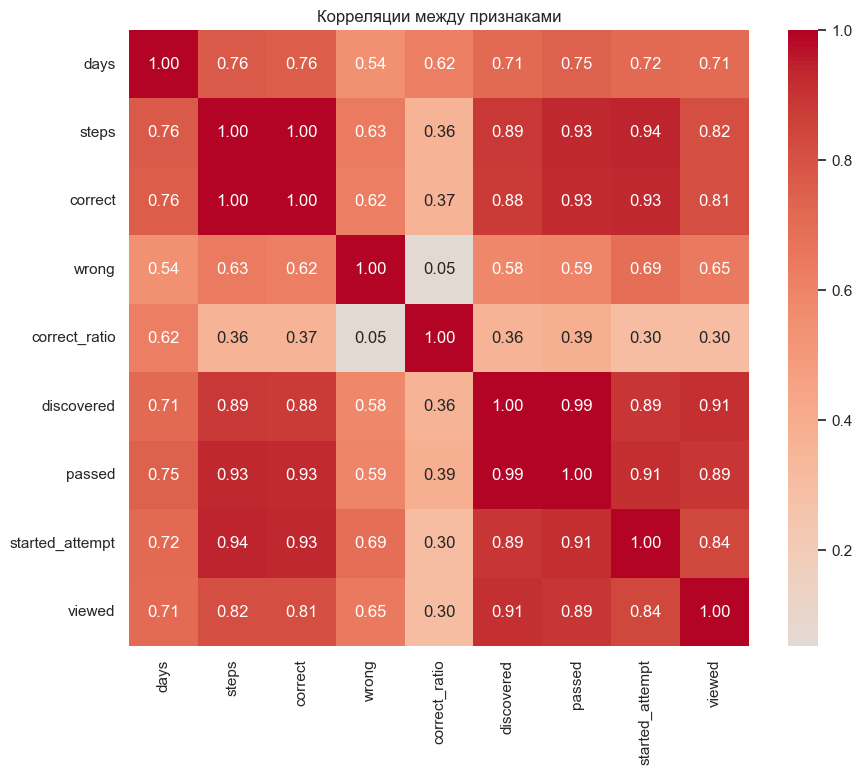

In [285]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_features,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Корреляции между признаками")
plt.show()

In [291]:
#дропнем сильно коррелирующие фичи
X = X.drop(['discovered', 'passed', 'viewed', 'correct', 'steps'], axis = 1) 
X

,days,wrong,correct_ratio,started_attempt
user_id,,,,
1,0.0,0.0,0.000000,0
2,1.0,0.0,1.000000,2
3,1.0,4.0,0.500000,4
5,0.0,0.0,0.000000,0
7,0.0,0.0,0.000000,0
...,...,...,...,...
26790,1.0,0.0,1.000000,1
26793,0.0,0.0,0.000000,1
26794,3.0,9.0,0.775000,32


In [292]:
target = "passed_course"

features = [
    "days",
    "wrong",
    "correct_ratio",
    "started_attempt"
]

In [293]:
corr_features = X[features].corr()
corr_features

,days,wrong,correct_ratio,started_attempt
days,1.000000,0.541198,0.622270,0.716380
wrong,0.541198,1.000000,0.051983,0.690103
correct_ratio,0.622270,0.051983,1.000000,0.303056
started_attempt,0.716380,0.690103,0.303056,1.000000


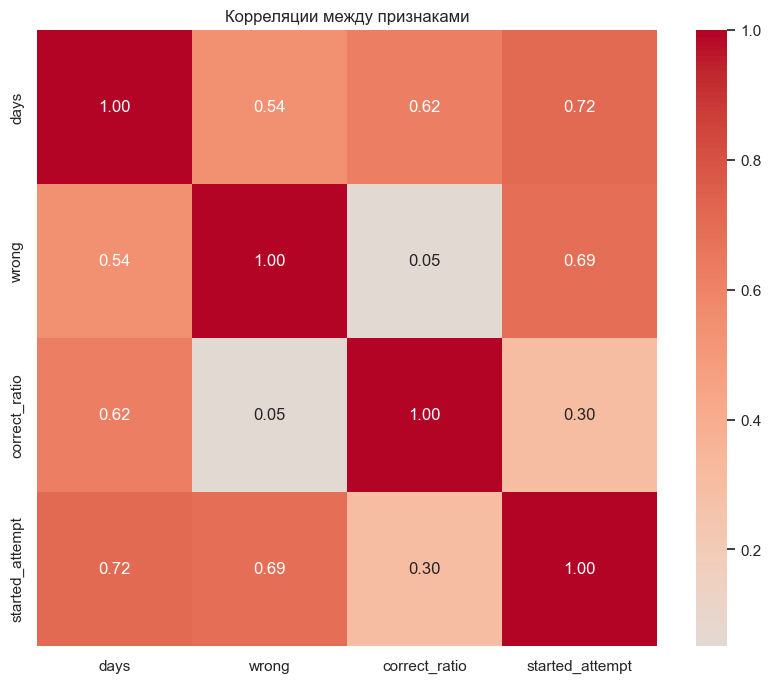

In [294]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_features,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Корреляции между признаками")
plt.show()

Разбиваем на трейн и тест выборки:

In [297]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y #для сохранения баланса 80/20 и в трейн, и в тест
)

## Random forest

In [299]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)

In [300]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1)

In [301]:
params = {"n_estimators": [200, 300, 500, 800, 1000],
          "max_depth": [None] + list(range(5, 21)),
          "min_samples_split": range(2, 21),
          "min_samples_leaf": range(1, 11),
          "max_features": ["sqrt", None, 0.7], #сколько фичей берем
          "class_weight": ["balanced"]} #из-за дисбаланса классов назначаем меньшему классу вес побольше

In [306]:
random = RandomizedSearchCV(rf,
                            params,
                            n_iter=50,
                            scoring="roc_auc", #по умолчанию accuracy не подходит из-за дисбаланса классов
                            cv=5, 
                            verbose=2, #вывод логирования
                            random_state=42,
                            n_jobs=-1)

In [308]:
random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [None, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14, 15, 16,
                                                      17, 18, 19, 20],
                                        'max_features': ['sqrt', None, 0.7],
                                        'min_samples_leaf': range(1, 11),
                                        'min_samples_split': range(2, 21),
                                        'n_estimators': [200, 300, 500, 800,
                                                         1000]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [309]:
print("\nBest parameters:")
print(random.best_params_)

print("\nBest CV ROC-AUC:")
print(random.best_score_)


Best parameters:
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 5, 'class_weight': 'balanced'}

Best CV ROC-AUC:
0.8351279653848753


In [311]:
#лушая модель
best_rf = random.best_estimator_

In [343]:
importances = best_rf.feature_importances_

pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

,feature,importance
3,started_attempt,0.335284
2,correct_ratio,0.332371
0,days,0.305343
1,wrong,0.027001


In [326]:
# Предсказание вероятностей
y_proba = best_rf.predict_proba(X_test)[:, 1] #возвращает не метки классов, а вероятности, нужно для метрик
y_pred = best_rf.predict(X_test) 

In [327]:
roc_auc = roc_auc_score(y_test, y_proba)

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

In [328]:
print("\nTest ROC-AUC:", roc_auc)
print("Test PR-AUC:", pr_auc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test ROC-AUC: 0.8276559454191034
Test PR-AUC: 0.3486828813667505

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      3312
           1       0.20      0.80      0.32       285

    accuracy                           0.73      3597
   macro avg       0.59      0.76      0.57      3597
weighted avg       0.92      0.73      0.79      3597


Confusion Matrix:
[[2390  922]
 [  57  228]]


Это хороший результат, если наша цель - точно найти всех тех, кто успешно завершит курс (и неважно, что случайно определим некоторых ушедших с курса как успешно завершивших его).
Но в случае, если нам важен другой класс, или важен баланс классов, нужно потюнить пороговое значение. Попробуем сделать сбалансированную модель:

In [344]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

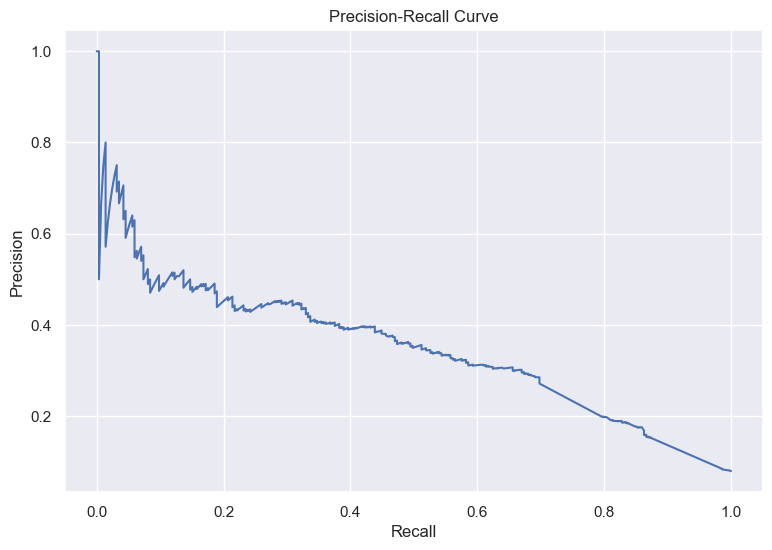

In [345]:
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [331]:
#чтобы найти порог со сбалансированным значение precisiion и recall, воспользуемся метрикой F1
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print("Best threshold (F1):", best_threshold)
print("Precision:", precision[best_index])
print("Recall:", recall[best_index])
print("F1:", f1_scores[best_index])

Best threshold (F1): 0.7277149882480141
Precision: 0.35609756097560974
Recall: 0.512280701754386
F1: 0.42014388005382747


In [332]:
y_pred_custom = (y_proba > 0.72).astype(int)

In [333]:
roc_auc = roc_auc_score(y_test, y_proba)

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

In [335]:
print("\nTest ROC-AUC:", roc_auc)
print("Test PR-AUC:", pr_auc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))


Test ROC-AUC: 0.8276559454191034
Test PR-AUC: 0.3486828813667505

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3312
           1       0.35      0.51      0.42       285

    accuracy                           0.89      3597
   macro avg       0.65      0.72      0.68      3597
weighted avg       0.91      0.89      0.90      3597


Confusion Matrix:
[[3040  272]
 [ 139  146]]


Порог классификации был оптимизирован по F1-score на основе Precision-Recall кривой, что позволило добиться лучшего баланса между полнотой и точностью для minority класса.

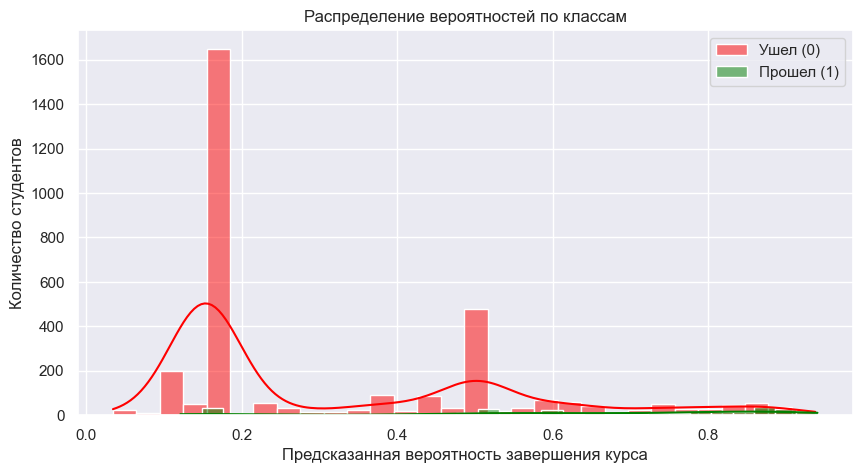

In [336]:
# создаем DataFrame для удобства
df_plot = pd.DataFrame({
    "y_true": y_test,
    "y_proba": y_proba
})

plt.figure(figsize=(10,5))

# распределение вероятностей по классам
sns.histplot(df_plot[df_plot["y_true"]==0]["y_proba"], 
             color="red", label="Ушел (0)", kde=True, bins=30, alpha=0.5)
sns.histplot(df_plot[df_plot["y_true"]==1]["y_proba"], 
             color="green", label="Прошел (1)", kde=True, bins=30, alpha=0.5)

plt.xlabel("Предсказанная вероятность завершения курса")
plt.ylabel("Количество студентов")
plt.title("Распределение вероятностей по классам")
plt.legend()
plt.show()


Красная область => студенты, которые ушли (класс 0)

Зеленая область => студенты, которые прошли (класс 1)

По оси X - вероятность предсказания модели

Чем больше пересечение, тем сложнее разделить классы

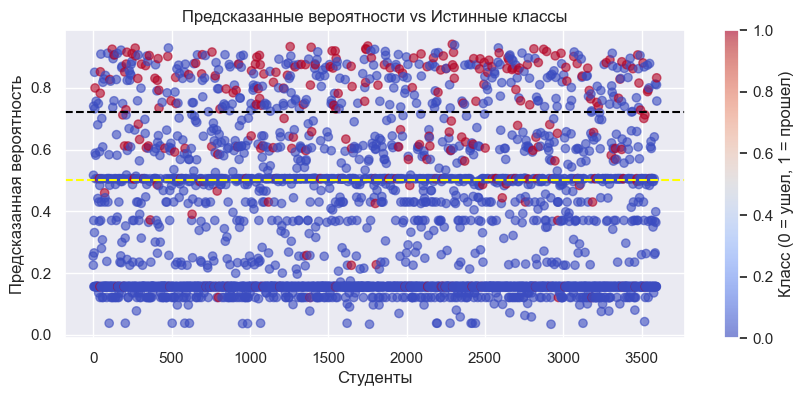

In [341]:
plt.figure(figsize=(10,4))
plt.scatter(range(len(y_test)), y_proba, c=y_test, cmap="coolwarm", alpha=0.6)
plt.axhline(0.72, color="black", linestyle="--", label="threshold1=0.72")
plt.axhline(0.5, color="yellow", linestyle="--", label="threshold2=0.5")
plt.xlabel("Студенты")
plt.ylabel("Предсказанная вероятность")
plt.title("Предсказанные вероятности vs Истинные классы")
plt.colorbar(label="Класс (0 = ушел, 1 = прошел)")
plt.show()


На оси X - студенты

На оси Y - вероятность модели

Цвет показывает истинный класс

Желтая пунктирная линия - порог 0.5 с повышенным recall для группы 1
Черная пунктирная линия - порог 0.72 с балансом precision и recall для группы 1 (заодно повысили recall для группы 0)

* Random Forest показывает хорошую способность к ранжированию студентов по вероятности завершения курса (ROC-AUC 0.828).

* PR-AUC 0.349 подтверждает, что модель выделяет minority класс лучше случайной модели.

* Выбор порога позволяет управлять компромиссом между precision и recall для класса 1:

    * Порог 0.5 => максимальная полнота, больше ложных срабатываний
    
    * Порог 0.72 => выше точность, меньше ложных срабатываний, но теряется часть recall

* Для дальнейшего улучшения модели можно:

    1. Добавлять новые поведенческие признаки
    
    2. Пробовать градиентные бустинги (LightGBM, XGBoost, CatBoost)
    
    3. Продолжить оптимизацию threshold под бизнес-задачу

## Логистическая регрессия (с L2-регулризацией)

In [347]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (average_precision_score)

In [348]:
#стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [356]:
#обучаем логистическую регрессию
#используем balanced class weight для дисбаланса
lr = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42) #penalty по умолчанию "l2"
lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [357]:
#предсказания
y_proba = lr.predict_proba(X_test_scaled)[:, 1] # вероятность класса 1
y_pred = lr.predict(X_test_scaled) # бинарные предсказания по порогу 0.5

In [358]:
#метрики
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("Logistic Regression Metrics:")
print("Test ROC-AUC:", roc_auc)
print("Test PR-AUC:", pr_auc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Logistic Regression Metrics:
Test ROC-AUC: 0.8234712687515892
Test PR-AUC: 0.3440422194770364

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80      3312
           1       0.18      0.82      0.30       285

    accuracy                           0.69      3597
   macro avg       0.58      0.75      0.55      3597
weighted avg       0.91      0.69      0.76      3597

Confusion Matrix:
[[2239 1073]
 [  50  235]]


In [359]:
#Precision-Recall кривая и оптимальный порог по F1
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print("\nBest threshold by F1 (PR curve):", best_threshold)
print("Precision:", precision[best_index])
print("Recall:", recall[best_index])
print("F1:", f1_scores[best_index])


Best threshold by F1 (PR curve): 0.6640568204601113
Precision: 0.3346938775510204
Recall: 0.5754385964912281
F1: 0.42322580180145686


In [360]:
# бинарные предсказания по оптимальному порогу
y_pred_custom = (y_proba >= best_threshold).astype(int)
print("\nClassification Report (custom threshold):")
print(classification_report(y_test, y_pred_custom))
print("Confusion Matrix (custom threshold):")
print(confusion_matrix(y_test, y_pred_custom))


Classification Report (custom threshold):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3312
           1       0.33      0.58      0.42       285

    accuracy                           0.88      3597
   macro avg       0.65      0.74      0.68      3597
weighted avg       0.91      0.88      0.89      3597

Confusion Matrix (custom threshold):
[[2986  326]
 [ 121  164]]


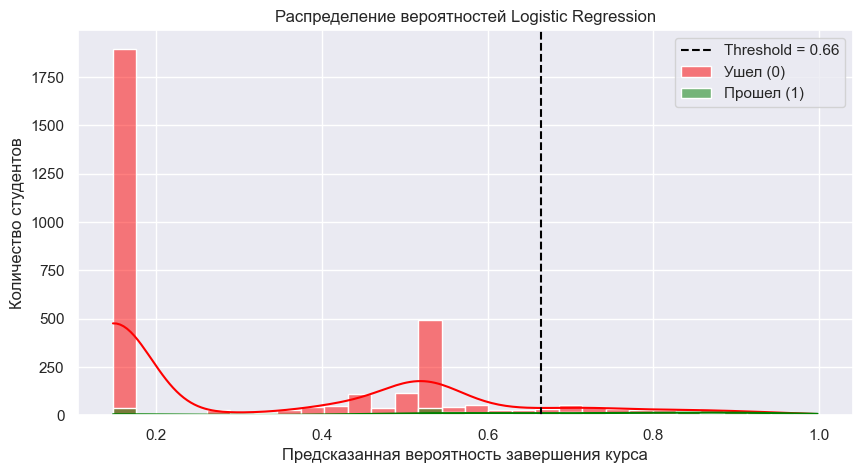

In [361]:
#визуализация распределения вероятностей
plt.figure(figsize=(10,5))
sns.histplot(y_proba[y_test==0], color="red", label="Ушел (0)", kde=True, bins=30, alpha=0.5)
sns.histplot(y_proba[y_test==1], color="green", label="Прошел (1)", kde=True, bins=30, alpha=0.5)
plt.axvline(best_threshold, color="black", linestyle="--", label=f"Threshold = {best_threshold:.2f}")
plt.xlabel("Предсказанная вероятность завершения курса")
plt.ylabel("Количество студентов")
plt.title("Распределение вероятностей Logistic Regression")
plt.legend()
plt.show()

In [362]:
# 9️⃣ Важность признаков (коэффициенты)
feat_importance = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lr.coef_[0]
}).sort_values(by="coefficient", ascending=False)
print("\nFeature importance (logistic regression):")
print(feat_importance)


Feature importance (logistic regression):
           feature  coefficient
0             days     0.626503
2    correct_ratio     0.435102
3  started_attempt     0.416094
1            wrong     0.061537


## Итог:

После подбора оптимального порога логистическая регрессия и Random Forest показали сопоставимые результаты (F1 = 0.42, ROC-AUC ≈ 0.82–0.83). Это говорит о том, что структура данных в значительной степени линейна, и более сложная модель (Random Forest) не даёт существенного прироста качества. Следовательно, выбор модели может определяться интерпретируемостью и бизнес-требованиями, а не только метриками качества.
Для продакшена в данном случае я бы выбрала логистическую регрессию из-за интерпретируемости.